## Notebook to analyze if we see a citation increase over time, and now we might model it

In [1]:
import pandas as pd
import json
import sys
sys.path.append("../src")
from process import *
from fitting_util import *
from plotting import *

In [2]:
# how far out we should try to fit the data
# the lower the year, the greater the baseline to fit
earliest_year = 1900 # 2010 

In [3]:
# load data
import statistics as stat
# used make_citation_dataset.py to get this data
fname = "../data/doc_citations.json"
#fname = "../data/astro_only_doc_citation_bibcode_cnts_2010.json"
with open (fname, 'r') as f:
    raw_data = json.load(f)

In [4]:
#len(raw_data.keys()), sorted(raw_data.keys())

In [5]:
proc_data = {}
for year in raw_data.keys():
    yr = int(year)
    if yr >= earliest_year:
        proc_data[yr] = raw_data[year]

In [6]:
from bootstrap_stat import bootstrap_stat as bp
# look at scatter in citations for older journals to try to understand errors.
# looks like a powerlaw distribution. Use bootstrap error estimation.

def statistic(df):
    # this is mean
    if isinstance(df, list):
        return stat.mean(df) # stat.median(df)
    else:
        return stat.mean(list(df['data'])) # stat.median(list(df['data']))


y_err_all = {}
for year in proc_data.keys():
    
    df = pd.DataFrame({'data': proc_data[year]})
    dist = bp.EmpiricalDistribution(df)
    #print (dist)  
    #print(statistic(df))
    y_err_all[year] = bp.standard_error(dist, statistic, robustness=0.99)
    
    # leads to huge variance
    #y_err_all[year] = stat.pvariance(raw_data[year])
  

In [7]:
print (y_err_all)

{2011: 1.1853314741428056, 2001: 1.5696042977885025, 2006: 1.6383847001997556, 2010: 1.026424171393753, 2000: 1.757987580020631, 2005: 1.5345559954529893, 2007: 1.3824960651394207, 2004: 1.3522070940403503, 2017: 0.3269349790090127, 2016: 0.9042343415648845, 2013: 1.0015479103050184, 2012: 0.7093687366729964, 2019: 0.17763272961677778, 2015: 0.48045817642298133, 2014: 0.9694957631258585, 1999: 2.8419678663858217, 2003: 2.2901066286019254, 1998: 3.303896738309688, 2018: 0.42279644895207336, 2002: 1.25449147464238, 2008: 0.91111456124217, 2009: 1.3681435849565071}


In [8]:
# if we cannot get an error, drop the point
use_year = []
y_errs = {}
for yr in y_err_all.keys():
    if y_err_all[yr] > 0.:
        use_year.append(yr)
        y_errs[yr] = y_err_all[yr]
#use_year

In [9]:
data = {}
# counts = {}
for yr in sorted(use_year):
    iyr = int(yr)
    data[iyr] = statistic(proc_data[yr])
    # counts[iyr] = stat.sqrt(len(raw_data[yr]))

x = [2021-k for k, v in sorted(data.items(), key=lambda item: item[0], reverse=False)]
y = [v for k, v in sorted(data.items(), key=lambda item: item[0], reverse=False)]
y_err = [v for k, v in sorted(y_errs.items(), key=lambda item: item[0], reverse=False)]

(array([4.40662303, 3.61383512]),
 array([1.33807707, 0.21662605]),
 52.27379236648096)

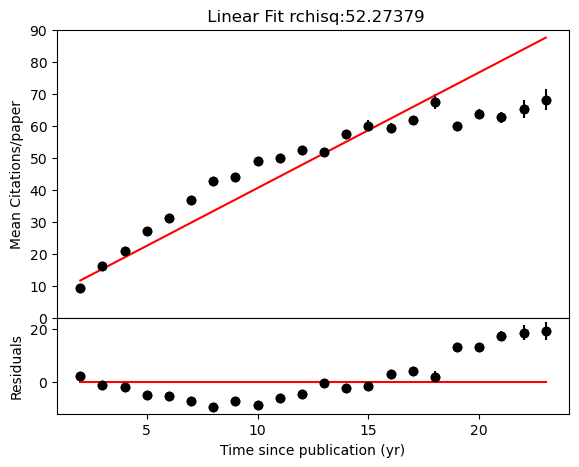

In [19]:
# Linear Fit
linefit = lambda p, x : np.array([(p[1] * dx) + p[0] for dx in x])
pfit, perr, redchisq = fit_leastsq([0.,2.], np.array(x), np.array(y), linefit, np.array(y_err))
plotdata_and_residuals (plt, f'Linear Fit rchisq:%8.5f' % redchisq, x, y, y_err, pfit, redchisq, linefit, ylim=[0.,90.],
                       ylabel="Mean Citations/paper", xlabel='Time since publication (yr)')

plt.savefig(f'../plots/linear_cites_vs_time.jpg', transparent=False, dpi=600)

pfit, perr, redchisq

(array([93.15189062, 10.8211801 ]),
 array([7.77826865, 1.26157564]),
 12.697544966598851)

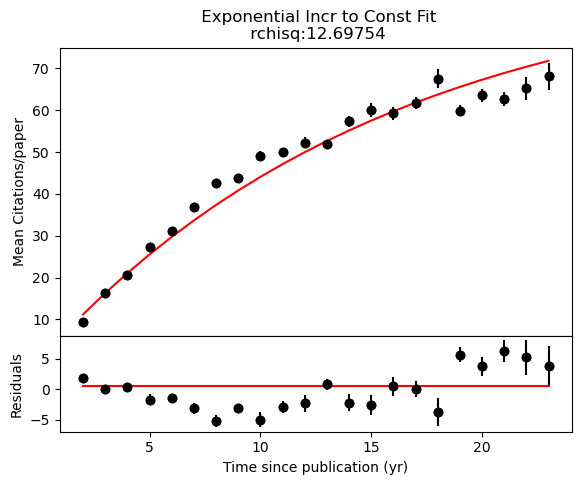

In [11]:
# Exponentially increase to constant Fit
exp_fit = lambda p, x : np.array([p[0] * (1. - (0.5) ** (dx/p[1])) for dx in x])
pfit, perr, redchisq = fit_leastsq([35.,5.6], np.array(x), np.array(y), exp_fit, np.array(y_err))
ax = plotdata_and_residuals (plt, f'Exponential Incr to Const Fit\n rchisq:%8.5f' % redchisq, 
                             x, y, y_err, pfit, redchisq, exp_fit,
                            ylabel="Mean Citations/paper", xlabel='Time since publication (yr)')
pfit, perr, redchisq

(array([59.2165963 , 10.59347361, -0.40749131]),
 array([1.49969461, 0.86438372, 0.02248178]),
 9.188084116627342)

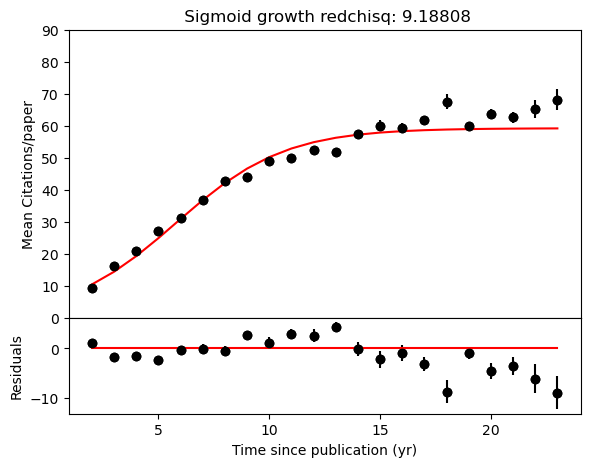

In [17]:
# Logistic (sigmoid) growth fit
import math
#sig_fit = lambda p, x : np.array([(p[0] / (1 + (p[1] * math.exp(p[2] * dx)))) for dx in x])
#sig_fit = lambda p, x : np.array([(p[0] / (1 + math.exp(p[1] * dx))) for dx in x])
#sig_fit = lambda p, x : np.array([((p[0] / (1 + (p[1] * math.exp(p[2] * dx)))) + p[3]) for dx in x])
sig_fit = lambda p, x : np.array([(p[0] / (1 + p[1]*math.exp(dx * p[2]))) for dx in x])

pfit, perr, redchisq = fit_leastsq([70., 10., -0.1], np.array(x), np.array(y), sig_fit, np.array(y_err))
ax = plotdata_and_residuals (plt, f'Sigmoid growth redchisq:%8.5f' % redchisq, 
                             x, y, y_err, pfit, redchisq, sig_fit, ylim=[0., 90.],
                            ylabel="Mean Citations/paper", xlabel='Time since publication (yr)')

plt.savefig(f'../plots/log_sig_cites_vs_time.jpg', transparent=False, dpi=600)

pfit, perr, redchisq

(array([139.39612198,  -0.18276842, -72.86742801]),
 array([2.18362438, 0.00661062, 1.14438429]),
 2.0523110643956337)

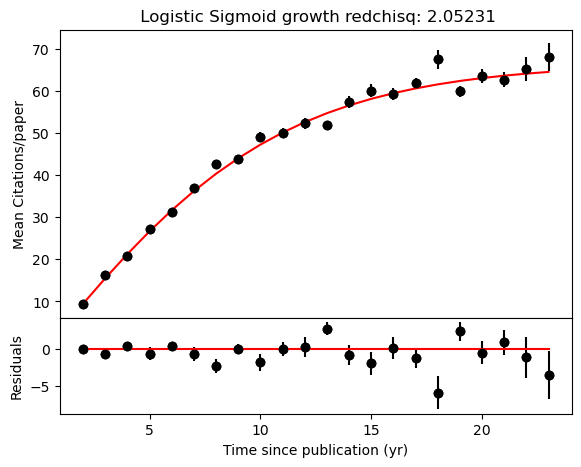

In [13]:
# Logistic (sigmoid) growth fit
import math
sig_fit = lambda p, x : np.array([((p[0] / (1 + math.exp(dx * p[1]))) + p[2]) for dx in x])

#pfit, perr, redchisq = fit_leastsq([70., 10., -0.1, 0.], np.array(x), np.array(y), sig_fit, np.array(y_err))
pfit, perr, redchisq = fit_leastsq([70., -0.1, 0.], np.array(x), np.array(y), sig_fit, np.array(y_err))
ax = plotdata_and_residuals (plt, f'Logistic Sigmoid growth redchisq:%8.5f' % redchisq, 
                             x, y, y_err, pfit, redchisq, sig_fit,
                            ylabel="Mean Citations/paper", xlabel='Time since publication (yr)')
pfit, perr, redchisq

(array([18.27270422]), array([0.65090914]), 53.079200400696536)

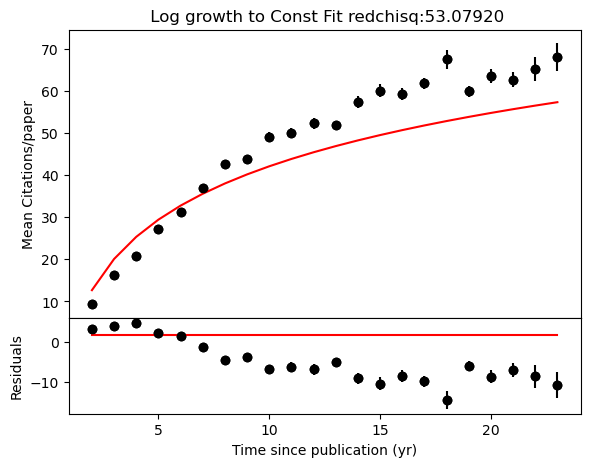

In [14]:
# Logarithmic growth fit
import math
log_fit = lambda p, x : np.array([(p[0] * math.log(dx)) for dx in x])

pfit, perr, redchisq = fit_leastsq([1.], np.array(x), np.array(y), log_fit, np.array(y_err))
ax = plotdata_and_residuals (plt, f'Log growth to Const Fit redchisq:%8.5f' % redchisq, 
                             x, y, y_err, pfit, redchisq, log_fit,
                            ylabel="Mean Citations/paper", xlabel='Time since publication (yr)')
pfit, perr, redchisq